In [1]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS backend available ✅")
    print(f"Using device: {device}")
else:
    device = torch.device("cpu")
    print("MPS not available ❌, using CPU")

MPS backend available ✅
Using device: mps


In [4]:
import gc, psutil, os

def memory_report():
    total_elements = 0
    total_bytes = 0

    # Go through all live tensors
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                total_elements += obj.numel()
                total_bytes += obj.element_size() * obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                total_elements += obj.data.numel()
                total_bytes += obj.data.element_size() * obj.data.numel()
        except Exception:
            pass

    total_mb = total_bytes / (1024 ** 2)

    process = psutil.Process(os.getpid())
    rss_mb = process.memory_info().rss / (1024 ** 2)

    print("\n--- MEMORY USAGE REPORT ---")
    print(f"Tensors Allocated: {total_elements:,}")
    print(f"Tensor Memory:     {total_mb:.2f} MB")
    print(f"Process RSS:       {rss_mb:.2f} MB")
    print("---------------------------\n")

In [5]:
# Allocate a big tensor on MPS to test
x = torch.rand((8000, 8000), device=device)  
memory_report()


--- MEMORY USAGE REPORT ---
Tensors Allocated: 64,000,000
Tensor Memory:     244.14 MB
Process RSS:       246.16 MB
---------------------------



/var/folders/19/6jsh26815bq0m281bn69tt9w0000gn/T/ipykernel_1053/2450541917.py:13: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  elif hasattr(obj, "data") and torch.is_tensor(obj.data):


In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

training_pipeline = A.Compose([

    A.Resize(height=224, width=224),
    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.7),
    A.GridDistortion(p=0.3),
    
    A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.4),

    A.OneOf([
        A.GaussNoise(std_range=(0.1, 0.2), per_channel=True, p=0.4),
        A.CoarseDropout(num_holes_range=(1, 8), hole_height_range=(0.1, 0.25), hole_width_range=(0.1, 0.25), fill=0, p=0.5)
    ], p=0.5),

    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

validation_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

basic_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.6),
    A.VerticalFlip(p=0.6),
    A.Rotate(limit=(-45,45), p=0.7),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [8]:
import random
import shutil
from pathlib import Path
from tqdm import tqdm

def prepare_image_datasets(source_dir, base_dir, split_ratios=(0.7, 0.1, 0.2)):

     if not (0.999 < sum(split_ratios) < 1.001):
             raise ValueError('split_ratios must sum to 1')

     source_path = Path(source_dir)
     base_path = Path(base_dir)

     if not source_path.is_dir():
         print(f'Source directory {source_path.name} does not exist')
         return

     train_path = base_path / 'train'
     test_path = base_path / 'test'
     val_path = base_path / 'val'

     class_names = [d.name for d in source_path.iterdir() if d.is_dir()]

     if not class_names:
         print(f'Source directory {source_path.name} does not contain any class names')
         return

     for directory in [train_path, test_path, val_path]:
         for class_name in class_names:
             (directory / class_name).mkdir(parents=True, exist_ok=True)

     for class_name in class_names:

         class_source_path = source_path / class_name

         files = [f for f in class_source_path.iterdir() if f.is_file()]

         random.shuffle(files)

         total_files = len(files)
         train_end = int(total_files * split_ratios[0])
         test_end = train_end + int(total_files * split_ratios[1])

         split_data = {
             'train': (files[:train_end], train_path),
             'test': (files[train_end:test_end], test_path),
             'val': (files[test_end:], val_path)
         }

         print(f"Copying {class_name} to {base_path}")

         for split_name, (file_list, destination_path) in split_data.items():

             dest_class_path = destination_path / class_name

             for file_path in tqdm(file_list, desc=f'Copying {split_name} files'):

                 shutil.copy2(file_path, dest_class_path / file_path.name)

         print(f'Copying {class_name} finished!')

     print("Data splitting successful!")

In [9]:
import cv2
from torchvision import datasets

class CustomDataset(datasets.ImageFolder):

    def __getitem__(self, index):

        path, target = self.samples[index]

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, target

    def __len__(self):
        return len(self.samples)

In [8]:
source_data_dir = ''
base_data_dir = ''

if not source_data_dir or not base_data_dir:
    raise ValueError('Source and base data directory not found')

prepare_image_datasets(source_data_dir, base_data_dir, split_ratios=(0.7, 0.1, 0.2))

Copying sheath_blight to /Users/jameskierdoliguez/Desktop/rice_leaf/aug_dataset


Copying val files: 100%|████████████████████| 317/317 [00:00<00:00, 2996.22it/s]


Copying sheath_blight finished!
Copying Brownspot to /Users/jameskierdoliguez/Desktop/rice_leaf/aug_dataset


Copying val files: 100%|████████████████████| 301/301 [00:00<00:00, 5466.35it/s]


Copying Brownspot finished!
Copying Blast to /Users/jameskierdoliguez/Desktop/rice_leaf/aug_dataset


Copying val files: 100%|████████████████████| 289/289 [00:00<00:00, 4883.23it/s]


Copying Blast finished!
Copying Bacterialblight to /Users/jameskierdoliguez/Desktop/rice_leaf/aug_dataset


Copying val files: 100%|████████████████████| 318/318 [00:00<00:00, 5593.18it/s]


Copying Bacterialblight finished!
Copying Tungro to /Users/jameskierdoliguez/Desktop/rice_leaf/aug_dataset


Copying val files: 100%|████████████████████| 263/263 [00:00<00:00, 6054.31it/s]

Copying Tungro finished!
Data splitting successful!


In [27]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

class LeafDiseaseClassifierMobileNetV2(nn.Module):

    def __init__(self, num_classes):
        super(LeafDiseaseClassifierMobileNetV2, self).__init__()

        # get model
        self.base_model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')

        # Froze feature extraction layer to retain weights.
        for params in self.base_model.parameters():
            params.requires_grad = False

        # get number of features
        num_filters = self.base_model.classifier[1].in_features

        # Hyperparameter tuning: new layer for 6 rice pests.
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),

            nn.Linear(num_filters, 512),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(512, num_classes),
        )

    # Forward propagation
    def forward(self, x):

       features = self.base_model.features(x)

       # features = F.adaptive_max_pool2d(features, output_size=(1, 1)).reshape(features.shape[0], -1)

       avg_pool = F.adaptive_avg_pool2d(features, output_size=(1, 1))
       max_pool = F.adaptive_max_pool2d(features, output_size=(1, 1))
       features = torch.cat([avg_pool, max_pool], dim=1).reshape(features.shape[0], -1)
       
       #features = F.adaptive_avg_pool2d(features, output_size=(1, 1)).reshape(features.shape[0], -1)

       features = self.base_model.classifier(features)

       return features

    def unfreeze_layer(self, layer):

        if not (1 <= layer <= len(self.base_model.features)):
            print(f"Error: Invalid layer index {layer}.")
            return

        # Corrected print statement
        print(f"\nUnfreezing feature layer at index: -{layer}")

        for param in self.base_model.features[-layer].parameters():
            param.requires_grad = True


In [25]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

class LeafDiseaseClassifierMobileNetV3L(nn.Module):

    def __init__(self, num_classes):
        super(LeafDiseaseClassifierMobileNetV3L, self).__init__()

        # get model
        self.base_model = models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.IMAGENET1K_V2')

        # Froze feature extraction layer to retain weights.
        for params in self.base_model.parameters():
            params.requires_grad = False

        # get number of features
        num_filters = self.base_model.classifier[0].in_features

        # Hyperparameter tuning: new layer for number of classes
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),
            nn.Linear(num_filters, num_classes),
        )

    # Forward propagation
    def forward(self, x):

       features = self.base_model.features(x)

       features = F.adaptive_avg_pool2d(features, output_size=(1, 1)).reshape(features.shape[0], -1)

       features = self.base_model.classifier(features)

       return features

    def unfreeze_layer(self, layer):

        if not (1 <= layer <= len(self.base_model.features)):
            print(f"Error: Invalid layer index {layer}.")
            return

        # Corrected print statement
        print(f"\nUnfreezing feature layer at index: -{layer}")

        for param in self.base_model.features[-layer].parameters():
            param.requires_grad = True


In [11]:
class LeafDiseaseClassifierEfficientNetV2S(nn.Module):

    def __init__(self, num_classes):
        super(LeafDiseaseClassifierEfficientNetV2S, self).__init__()

        self.base_model = models.efficientnet_v2_s(weights='EfficientNet_V2_S_Weights.IMAGENET1K_V1')

        for params in self.base_model.parameters():
            params.requires_grad = False

        features = self.base_model.classifier[1].in_features

        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(features, num_classes),
        )

    def forward(self, x):

        features = self.base_model.features(x)

        features = F.adaptive_avg_pool2d(features, output_size=(1, 1)).reshape(features.shape[0], -1)

        features = self.base_model.classifier(features)

        return features

    def unfreeze_layer(self, layer):

        if not (1 <= layer <= len(self.base_model.features)):
            print(f"Error: Invalid layer index {layer}.")
            return

        print(f"\nUnfreezing feature layer at index: -{layer}")

        for params in self.base_model.features[-layer].parameters():
            params.requires_grad = True


In [12]:
class LeafDiseaseClassifierShuffleNetV2(nn.Module):

    def __init__(self, num_classes):
        super(LeafDiseaseClassifierShuffleNetV2, self).__init__()

        self.base_model = models.shufflenet_v2_x2_0(weights='ShuffleNet_V2_X2_0_Weights.IMAGENET1K_V1')

        for params in self.base_model.parameters():
            params.requires_grad = False

        features = self.base_model.fc.in_features

        self.base_model.fc = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(features, num_classes),
        )

    def forward(self, x):

        return self.base_model(x)

    def unfreeze_layer(self, layer):
        feature_blocks = [
            self.base_model.conv1,
            self.base_model.stage2,
            self.base_model.stage3,
            self.base_model.stage4,
            self.base_model.conv5
        ]

        if not (1 <= layer <= len(feature_blocks)):
            print(f"Error: Invalid layer index {layer}. Choose between 1 and {len(feature_blocks)}.")
            return

        print(f"\nUnfreezing feature block at index: -{layer}")

        # Unfreeze the parameters of the selected block from the end of the list.
        for params in feature_blocks[-layer].parameters():
            params.requires_grad = True


In [13]:
import torch
import numpy as np

def rand_bbox(size, lam):
    """Generates a random bounding box for the patch."""
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # Uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def train_and_validate(model, optimizer, criterion, train_dataloader, validation_dataloader, num_epoch, device, scheduler, model_dir, patience=3, min_delta=0.001):

    train_losses = []
    validation_losses = []
    accuracies = []
    patience_counter = 0
    best_validation_loss=float('inf')
    best_session_accuracy = float('inf')
    stop_early=False
    fully_stop = False

    for epoch in range(num_epoch):
        model.train()
        running_train_loss = 0.0
        train_pbar = tqdm(train_dataloader, desc=f"Train epoch: {epoch+1}")
        for data, labels in train_pbar:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()

            use_cutmix = True # You can make this conditional
            alpha = 1.0
            
            if use_cutmix and np.random.rand() < 0.5:
                # Generate a random index to mix with
                rand_index = torch.randperm(data.size()[0]).to(device)
                target_a = labels
                target_b = labels[rand_index]
                lam = np.random.beta(alpha, alpha)

                bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
                data[:, :, bbx1:bbx2, bby1:bby2] = data[rand_index, :, bbx1:bbx2, bby1:bby2]
                
                # Adjust lambda to match the actual patch area
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
                
                output = model(data)
                # Calculate the mixed loss
                loss = criterion(output, target_a) * lam + criterion(output, target_b) * (1. - lam)

            else:
                # Standard training if CutMix is not used
                output = model(data)
                loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        training_loss = running_train_loss / len(train_dataloader)
        train_losses.append(training_loss)

        model.eval()
        running_eval_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in tqdm(validation_dataloader, desc=f"Validate Epoch {epoch+1}"):
                inputs, labels = inputs.to(device), labels.to(device)

                logits = model(inputs)
                loss = criterion(logits, labels)
                running_eval_loss += loss.item()
                _, predicted = torch.max(logits.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        validation_loss = running_eval_loss / len(validation_dataloader)
        validation_losses.append(validation_loss)
        accuracy = 100 * correct_predictions / total_samples
        accuracies.append(accuracy)

        scheduler.step(validation_loss)

        current_lr = optimizer.param_groups[0]['lr']
        epoch_summary = f'Epoch {epoch+1}/{num_epoch} |lr: {current_lr}| Train Loss: {training_loss:.4f} | Evaluate Loss: {validation_loss:.4f} | Accuracy: {accuracy:.2f}%'

        if device.type == 'cuda':
            allocated_gb = torch.cuda.memory_allocated() / (1024 ** 3)
            reserved_gb = torch.cuda.memory_reserved() / (1024 ** 3)
            epoch_summary += f' | GPU Memory (Alloc/Reserved): {allocated_gb:.2f}/{reserved_gb:.2f} GB'
        
        elif device.type == 'mps':
            try:
                allocated_gb = torch.mps.current_allocated_memory() / (1024 ** 3)
                reserved_gb = torch.mps.driver_allocated_memory() / (1024 ** 3)
                epoch_summary += f' | MPS Memory (Alloc/Driver): {allocated_gb:.2f}/{reserved_gb:.2f} GB'
            except AttributeError:
                epoch_summary += " | MPS Memory: not available in this PyTorch version"

        tqdm.write(epoch_summary)

        if validation_loss < best_validation_loss - min_delta:

            patience_counter = 0
            best_validation_loss = validation_loss
            torch.save(model.state_dict(), model_dir)
        else:
            patience_counter += 1
            tqdm.write(f'No improvement for {patience_counter}/{patience} epochs')

        if  validation_loss >= training_loss:
            tqdm.write(f'Training stopped! Validation loss: {validation_loss:.4f} | Training loss: {training_loss:.4f}')
            fully_stop = True
            break

        if patience_counter >= patience:
            tqdm.write(f'Early stopping triggered after {patience_counter} epochs')
            stop_early = True
            break

    tqdm.write('Session complete')

    return {'train_loss': train_losses, 'validation_loss': validation_losses, 'accuracy': accuracies}, best_session_accuracy, stop_early, fully_stop

<h2>  Saving and plott</h2>

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

def plot_training_result(*results):

    full_training_loss = []
    full_validation_loss = []

    for result in results:
        train_loss = result.get('train_loss', [])
        full_training_loss.extend(train_loss)
        full_validation_loss.extend(result.get('validation_loss', []))

    total_epochs = len(full_training_loss)

    if total_epochs == 0:
        print("No data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    data = {
        'Epoch': epochs,
        'Training Loss': full_training_loss,
        'Validation Loss': full_validation_loss,
    }

    df = pd.DataFrame(data)

    df_long = df.melt(id_vars=['Epoch'], var_name='Loss Type', value_name='Loss')

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long, x='Epoch', y='Loss', hue='Loss Type', marker='o')

    plt.title('Training and Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_historical_results(file_name):

    data = pd.read_csv(file_name)

    df = pd.DataFrame(data)

    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    fig.suptitle('Training and Validation Loss Comparison', fontsize=16)

    historical_losses = df.melt(id_vars=['epoch'],value_vars=['train_loss', 'validation_loss'], var_name='Loss Type', value_name='Loss')

    sns.lineplot(data=historical_losses, hue='Loss Type', markers='o' ,x='epoch' , y='Loss', ax=axes[0])

    axes[0].set_title('Training and Validation Loss Comparison')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)
    axes[0].legend()

    sns.lineplot(data=df, x='epoch', y='accuracy', color='g', markers='o', ax=axes[1])
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].grid(True)

    plt.tight_layout(rect=(0, 0.03, 1, 0.95))

    plt.show()

def plot_accuracy(*results):

    full_accuracy = []

    for res in results:
        accuracy = res.get('accuracy', [])
        full_accuracy.extend(accuracy)

    total_epochs = len(full_accuracy)

    if total_epochs == 0:
        print("No accuracy data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    plt.figure(figsize=(10, 6))

    plt.plot(epochs, full_accuracy, label='Accuracy', marker='o', color='g')

    plt.title('Accuracy Evaluation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

def save_historical_data(history, filename):

    training_loss = history.get('train_loss', [])
    test_loss = history.get('validation_loss', [])
    accuracy = history.get('accuracy', [])

    data_dict = pd.DataFrame({
        'train_loss': training_loss,
        'validation_loss': test_loss,
        'accuracy': accuracy,
    })

    if os.path.exists(filename):
        print("historical data exists! Appending new data.")
        old_data = pd.read_csv(filename)
        combined_data = pd.concat([old_data, data_dict], ignore_index=True)

    else:
        print("Creating new historical data...")
        combined_data = data_dict

    combined_data['epoch'] = range(1, len(combined_data) + 1)

    combined_data = combined_data[['epoch', 'train_loss', 'validation_loss', 'accuracy']]

    combined_data.to_csv(filename, index=False)

    print("Historical data saved successfully!")



In [15]:
from torch.utils.data import DataLoader

train_set = CustomDataset(root='/Users/jameskierdoliguez/Desktop/rice_leaf/aug_dataset/train', transform=training_pipeline)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
validation_set = CustomDataset(root='/Users/jameskierdoliguez/Desktop/rice_leaf/aug_dataset/val', transform=validation_pipeline)
validation_loader = DataLoader(validation_set, batch_size=64, shuffle=True)
test_set = CustomDataset(root='/Users/jameskierdoliguez/Desktop/rice_leaf/aug_dataset/test', transform=validation_pipeline)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

classes = train_set.classes

In [16]:
from torch.optim import lr_scheduler

def incremental_training(model, sessions, criterion, train_dataloader, validation_dataloader, device, model_dir, filename):

    # --- New code to display image counts ---
    num_train_images = len(train_dataloader.dataset) 
    num_val_images = len(validation_dataloader.dataset) 
    print(f"--- Starting Incremental Training ---") 
    print(f"Training images: {num_train_images}")
    print(f"Validation images: {num_val_images}") # <-- new
    
    full_history = []
    accuracies = []  # <-- new: collect accuracies
    best_overall_accuracy = 0.0

    for i, session in enumerate(sessions):
        print(f"\n--- Starting Training Session {i+1}/{len(sessions)} ---")

        epochs = session['epochs']
        lr = session['lr']
        layer_to_unfreeze = session.get('unfreeze_layer', 0)

        if layer_to_unfreeze > 0:
            model.unfreeze_layer(layer_to_unfreeze)

        optimizer = optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()), 
            lr=lr, weight_decay=1e-2
        )
        scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer, factor=0.5, mode='min', patience=2, min_lr=1e-7
        )

        session_history, session_best_accuracy, stop_early, full_stop = train_and_validate(
            model, optimizer, criterion, train_dataloader, validation_dataloader,
            epochs, device, scheduler, model_dir
        )

        full_history.append(session_history)
        accuracies.append(session_best_accuracy)  # <-- track best accuracy per session
        save_historical_data(session_history, filename)

        if session_best_accuracy > best_overall_accuracy:
            best_overall_accuracy = session_best_accuracy

        if full_stop:
            print("Full stop triggered! Possible overfitting in further sessions.")
            break

        if stop_early:
            print("Early stopping triggered. Moving to next session or finishing training.")

    print(f"\n--- Incremental training finished. Best overall accuracy: {best_overall_accuracy:.2f}% ---")
    return full_history, accuracies  # <-- return both

In [ ]:
import torch.optim as optim

if torch.cuda.is_available():
    hardware = torch.device("cuda")
elif torch.backends.mps.is_available():
    hardware = torch.device("mps")
else:
    hardware = torch.device("cpu")
classes = 5

criterion = nn.CrossEntropyLoss()

model = LeafDiseaseClassifierMobileNetV2(num_classes=classes).to(hardware)

model_dir = '/Users/jameskierdoliguez/Desktop/models/MobileNetV2/MobileNetV2_rice_leaf_disease_classificationV4.pt'
file_name = '/Users/jameskierdoliguez/Desktop/train_results/MobileNetV2/MobileNetV2_rice_leaf_disease_classificationV4.csv'

training_sessions = [

    {'epochs': 20, 'lr': 5e-4, 'unfreeze_layer': 0},

    {'epochs': 30, 'lr': 1e-4, 'unfreeze_layer': 1},

    {'epochs': 40, 'lr': 5e-5, 'unfreeze_layer': 2},

    {'epochs': 50, 'lr': 1e-5, 'unfreeze_layer': 3},

]

result, accuracies = incremental_training(model=model, sessions=training_sessions, criterion=criterion, train_dataloader=train_loader, validation_dataloader=validation_loader, device=hardware, model_dir=model_dir, filename=file_name)

plot_training_result(*result)
plot_accuracy(*result)

In [ ]:
import torch.optim as optim

if torch.cuda.is_available():
    hardware = torch.device("cuda")
elif torch.backends.mps.is_available():
    hardware = torch.device("mps")
else:
    hardware = torch.device("cpu")
classes = 5

criterion = nn.CrossEntropyLoss()

model = LeafDiseaseClassifierEfficientNetV2S(num_classes=classes).to(hardware)

model_dir = '/Users/jameskierdoliguez/Desktop/models/EfficientNetV2S/EfficientNetV2S_rice_leaf_disease_classificationV2.pt'
file_name = '/Users/jameskierdoliguez/Desktop/train_results/EfficientNetV2S/EfficientNetV2S_rice_leaf_disease_classificationV2.csv'

training_sessions = [

    {'epochs': 20, 'lr': 5e-4, 'unfreeze_layer': 0},

    {'epochs': 30, 'lr': 1e-4, 'unfreeze_layer': 1},

    {'epochs': 40, 'lr': 5e-5, 'unfreeze_layer': 2},

    {'epochs': 50, 'lr': 1e-5, 'unfreeze_layer': 3},
    
]

result, accuracies = incremental_training(model=model, sessions=training_sessions, criterion=criterion, train_dataloader=train_loader, validation_dataloader=validation_loader, device=hardware, model_dir=model_dir, filename=file_name)

plot_training_result(*result)
plot_accuracy(*result)

In [ ]:
import torch.optim as optim

if torch.cuda.is_available():
    hardware = torch.device("cuda")
elif torch.backends.mps.is_available():
    hardware = torch.device("mps")
else:
    hardware = torch.device("cpu")
classes = 5
criterion = nn.CrossEntropyLoss()

model = LeafDiseaseClassifierShuffleNetV2(num_classes=classes).to(hardware)

model_dir = '/Users/jameskierdoliguez/Desktop/models/ShuffleNetV2/ShuffleNetV2_rice_leaf_disease_classificationV1.pt'
file_name = '/Users/jameskierdoliguez/Desktop/train_results/ShuffleNetV2/ShuffleNetV2_rice_leaf_disease_classificationV1.csv'

training_sessions = [

    {'epochs': 20, 'lr': 5e-4, 'unfreeze_layer': 0},

    {'epochs': 30, 'lr': 1e-4, 'unfreeze_layer': 1},

    {'epochs': 40, 'lr': 5e-5, 'unfreeze_layer': 2},

    {'epochs': 50, 'lr': 1e-5, 'unfreeze_layer': 3},

]

result, accuracies = incremental_training(model=model, sessions=training_sessions, criterion=criterion, train_dataloader=train_loader, validation_dataloader=validation_loader, device=hardware, model_dir=model_dir, filename=file_name)

plot_training_result(*result)
plot_accuracy(*result)

--- Starting Incremental Training ---
Training images: 3628
Validation images: 1037

--- Starting Training Session 1/4 ---


Validate Epoch 1: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.93it/s]


Epoch 1/20 |lr: 0.0005| Train Loss: 1.5605 | Evaluate Loss: 1.4932 | Accuracy: 35.87% | MPS Memory (Alloc/Driver): 0.34/3.06 GB


Validate Epoch 2: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 2/20 |lr: 0.0005| Train Loss: 1.4549 | Evaluate Loss: 1.3927 | Accuracy: 44.17% | MPS Memory (Alloc/Driver): 0.34/4.06 GB


Validate Epoch 3: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.92it/s]


Epoch 3/20 |lr: 0.0005| Train Loss: 1.3743 | Evaluate Loss: 1.3189 | Accuracy: 51.59% | MPS Memory (Alloc/Driver): 0.34/4.06 GB


Validate Epoch 4: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 4/20 |lr: 0.0005| Train Loss: 1.3241 | Evaluate Loss: 1.2467 | Accuracy: 53.52% | MPS Memory (Alloc/Driver): 0.34/4.06 GB


Validate Epoch 5: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 5/20 |lr: 0.0005| Train Loss: 1.3130 | Evaluate Loss: 1.1993 | Accuracy: 58.05% | MPS Memory (Alloc/Driver): 0.34/4.06 GB


Validate Epoch 6: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 6/20 |lr: 0.0005| Train Loss: 1.2821 | Evaluate Loss: 1.1447 | Accuracy: 59.21% | MPS Memory (Alloc/Driver): 0.34/4.06 GB


Validate Epoch 7: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 7/20 |lr: 0.0005| Train Loss: 1.2830 | Evaluate Loss: 1.1069 | Accuracy: 61.43% | MPS Memory (Alloc/Driver): 0.34/4.06 GB


Validate Epoch 8: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 8/20 |lr: 0.0005| Train Loss: 1.2316 | Evaluate Loss: 1.0749 | Accuracy: 62.39% | MPS Memory (Alloc/Driver): 0.34/4.06 GB


Validate Epoch 9: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 9/20 |lr: 0.0005| Train Loss: 1.2119 | Evaluate Loss: 1.0459 | Accuracy: 62.87% | MPS Memory (Alloc/Driver): 0.34/4.06 GB


Validate Epoch 10: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 10/20 |lr: 0.0005| Train Loss: 1.2427 | Evaluate Loss: 1.0345 | Accuracy: 65.57% | MPS Memory (Alloc/Driver): 0.34/4.06 GB


Validate Epoch 11: 100%|████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 11/20 |lr: 0.0005| Train Loss: 1.2275 | Evaluate Loss: 1.0255 | Accuracy: 65.38% | MPS Memory (Alloc/Driver): 0.34/4.06 GB


Validate Epoch 12: 100%|████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 12/20 |lr: 0.0005| Train Loss: 1.1548 | Evaluate Loss: 0.9986 | Accuracy: 65.86% | MPS Memory (Alloc/Driver): 0.34/4.06 GB


Validate Epoch 13: 100%|████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 13/20 |lr: 0.0005| Train Loss: 1.2478 | Evaluate Loss: 0.9821 | Accuracy: 67.60% | MPS Memory (Alloc/Driver): 0.34/4.06 GB


Validate Epoch 14: 100%|████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 14/20 |lr: 0.0005| Train Loss: 1.2153 | Evaluate Loss: 0.9905 | Accuracy: 67.60% | MPS Memory (Alloc/Driver): 0.34/4.06 GB
No improvement for 1/3 epochs


Validate Epoch 15: 100%|████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 15/20 |lr: 0.0005| Train Loss: 1.1821 | Evaluate Loss: 0.9531 | Accuracy: 67.70% | MPS Memory (Alloc/Driver): 0.34/4.06 GB


Validate Epoch 16: 100%|████████████████████████| 17/17 [00:08<00:00,  1.97it/s]


Epoch 16/20 |lr: 0.0005| Train Loss: 1.2246 | Evaluate Loss: 0.9622 | Accuracy: 68.95% | MPS Memory (Alloc/Driver): 0.34/4.06 GB
No improvement for 1/3 epochs


Validate Epoch 17: 100%|████████████████████████| 17/17 [00:08<00:00,  1.93it/s]


Epoch 17/20 |lr: 0.0005| Train Loss: 1.2019 | Evaluate Loss: 0.9562 | Accuracy: 69.14% | MPS Memory (Alloc/Driver): 0.34/4.06 GB
No improvement for 2/3 epochs


Validate Epoch 18: 100%|████████████████████████| 17/17 [00:08<00:00,  1.92it/s]


Epoch 18/20 |lr: 0.0005| Train Loss: 1.2245 | Evaluate Loss: 0.9428 | Accuracy: 69.91% | MPS Memory (Alloc/Driver): 0.34/4.06 GB


Validate Epoch 19: 100%|████████████████████████| 17/17 [00:08<00:00,  1.92it/s]


Epoch 19/20 |lr: 0.0005| Train Loss: 1.1899 | Evaluate Loss: 0.9323 | Accuracy: 69.62% | MPS Memory (Alloc/Driver): 0.34/4.06 GB


Validate Epoch 20: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 20/20 |lr: 0.0005| Train Loss: 1.1663 | Evaluate Loss: 0.9211 | Accuracy: 69.33% | MPS Memory (Alloc/Driver): 0.34/4.06 GB
Session complete
Creating new historical data...
Historical data saved successfully!

--- Starting Training Session 2/4 ---

Unfreezing feature layer at index: -1


Validate Epoch 1: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 1/30 |lr: 0.0001| Train Loss: 1.1413 | Evaluate Loss: 0.9068 | Accuracy: 69.33% | MPS Memory (Alloc/Driver): 0.34/4.07 GB


Validate Epoch 2: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.92it/s]


Epoch 2/30 |lr: 0.0001| Train Loss: 1.1687 | Evaluate Loss: 0.9013 | Accuracy: 69.82% | MPS Memory (Alloc/Driver): 0.34/4.07 GB


Validate Epoch 3: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.92it/s]


Epoch 3/30 |lr: 0.0001| Train Loss: 1.2459 | Evaluate Loss: 0.8927 | Accuracy: 70.40% | MPS Memory (Alloc/Driver): 0.34/4.07 GB


Validate Epoch 4: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.92it/s]


Epoch 4/30 |lr: 0.0001| Train Loss: 1.1482 | Evaluate Loss: 0.8791 | Accuracy: 70.78% | MPS Memory (Alloc/Driver): 0.34/4.07 GB


Validate Epoch 5: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 5/30 |lr: 0.0001| Train Loss: 1.1197 | Evaluate Loss: 0.8661 | Accuracy: 70.59% | MPS Memory (Alloc/Driver): 0.34/4.07 GB


Validate Epoch 6: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.92it/s]


Epoch 6/30 |lr: 0.0001| Train Loss: 1.0991 | Evaluate Loss: 0.8683 | Accuracy: 71.17% | MPS Memory (Alloc/Driver): 0.34/4.07 GB
No improvement for 1/3 epochs


Validate Epoch 7: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.92it/s]


Epoch 7/30 |lr: 0.0001| Train Loss: 1.1280 | Evaluate Loss: 0.8555 | Accuracy: 71.46% | MPS Memory (Alloc/Driver): 0.34/4.07 GB


Validate Epoch 8: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.92it/s]


Epoch 8/30 |lr: 0.0001| Train Loss: 1.0971 | Evaluate Loss: 0.8384 | Accuracy: 71.84% | MPS Memory (Alloc/Driver): 0.34/4.07 GB


Validate Epoch 9: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.92it/s]


Epoch 9/30 |lr: 0.0001| Train Loss: 1.1374 | Evaluate Loss: 0.8421 | Accuracy: 72.03% | MPS Memory (Alloc/Driver): 0.34/4.07 GB
No improvement for 1/3 epochs


Validate Epoch 10: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 10/30 |lr: 0.0001| Train Loss: 1.1027 | Evaluate Loss: 0.8274 | Accuracy: 72.13% | MPS Memory (Alloc/Driver): 0.34/4.07 GB


Validate Epoch 11: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 11/30 |lr: 0.0001| Train Loss: 1.1142 | Evaluate Loss: 0.8162 | Accuracy: 72.03% | MPS Memory (Alloc/Driver): 0.34/4.07 GB


Validate Epoch 12: 100%|████████████████████████| 17/17 [00:08<00:00,  1.89it/s]


Epoch 12/30 |lr: 0.0001| Train Loss: 1.0896 | Evaluate Loss: 0.8191 | Accuracy: 72.23% | MPS Memory (Alloc/Driver): 0.34/4.07 GB
No improvement for 1/3 epochs


Validate Epoch 13: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 13/30 |lr: 0.0001| Train Loss: 1.1086 | Evaluate Loss: 0.8282 | Accuracy: 72.71% | MPS Memory (Alloc/Driver): 0.34/4.07 GB
No improvement for 2/3 epochs


Validate Epoch 14: 100%|████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 14/30 |lr: 0.0001| Train Loss: 1.1561 | Evaluate Loss: 0.7936 | Accuracy: 72.90% | MPS Memory (Alloc/Driver): 0.34/4.07 GB


Validate Epoch 15: 100%|████████████████████████| 17/17 [00:09<00:00,  1.88it/s]


Epoch 15/30 |lr: 0.0001| Train Loss: 1.1119 | Evaluate Loss: 0.7987 | Accuracy: 73.19% | MPS Memory (Alloc/Driver): 0.34/4.07 GB
No improvement for 1/3 epochs


Validate Epoch 16: 100%|████████████████████████| 17/17 [00:08<00:00,  1.92it/s]


Epoch 16/30 |lr: 0.0001| Train Loss: 1.1005 | Evaluate Loss: 0.7683 | Accuracy: 73.48% | MPS Memory (Alloc/Driver): 0.34/4.07 GB


Validate Epoch 17: 100%|████████████████████████| 17/17 [00:08<00:00,  1.92it/s]


Epoch 17/30 |lr: 0.0001| Train Loss: 1.1054 | Evaluate Loss: 0.7708 | Accuracy: 73.77% | MPS Memory (Alloc/Driver): 0.34/4.07 GB
No improvement for 1/3 epochs


Validate Epoch 18: 100%|████████████████████████| 17/17 [00:09<00:00,  1.88it/s]


Epoch 18/30 |lr: 0.0001| Train Loss: 1.0276 | Evaluate Loss: 0.7630 | Accuracy: 73.48% | MPS Memory (Alloc/Driver): 0.34/4.07 GB


Validate Epoch 19: 100%|████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 19/30 |lr: 0.0001| Train Loss: 1.1133 | Evaluate Loss: 0.7735 | Accuracy: 73.67% | MPS Memory (Alloc/Driver): 0.34/4.07 GB
No improvement for 1/3 epochs


Validate Epoch 20: 100%|████████████████████████| 17/17 [00:08<00:00,  1.89it/s]


Epoch 20/30 |lr: 0.0001| Train Loss: 1.0683 | Evaluate Loss: 0.7494 | Accuracy: 74.45% | MPS Memory (Alloc/Driver): 0.34/4.07 GB


Validate Epoch 21: 100%|████████████████████████| 17/17 [00:09<00:00,  1.87it/s]


Epoch 21/30 |lr: 0.0001| Train Loss: 1.1170 | Evaluate Loss: 0.7522 | Accuracy: 74.16% | MPS Memory (Alloc/Driver): 0.34/4.07 GB
No improvement for 1/3 epochs


Validate Epoch 22: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 22/30 |lr: 0.0001| Train Loss: 1.0312 | Evaluate Loss: 0.7493 | Accuracy: 73.96% | MPS Memory (Alloc/Driver): 0.34/4.07 GB
No improvement for 2/3 epochs


Validate Epoch 23: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 23/30 |lr: 0.0001| Train Loss: 1.0558 | Evaluate Loss: 0.7459 | Accuracy: 73.67% | MPS Memory (Alloc/Driver): 0.34/4.07 GB


Validate Epoch 24: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 24/30 |lr: 0.0001| Train Loss: 1.0897 | Evaluate Loss: 0.7301 | Accuracy: 75.31% | MPS Memory (Alloc/Driver): 0.34/4.07 GB


Validate Epoch 25: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 25/30 |lr: 0.0001| Train Loss: 1.0389 | Evaluate Loss: 0.7266 | Accuracy: 75.51% | MPS Memory (Alloc/Driver): 0.34/4.07 GB


Validate Epoch 26: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 26/30 |lr: 0.0001| Train Loss: 1.0454 | Evaluate Loss: 0.7332 | Accuracy: 75.60% | MPS Memory (Alloc/Driver): 0.34/4.07 GB
No improvement for 1/3 epochs


Validate Epoch 27: 100%|████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 27/30 |lr: 0.0001| Train Loss: 1.0732 | Evaluate Loss: 0.7138 | Accuracy: 75.51% | MPS Memory (Alloc/Driver): 0.34/4.07 GB


Validate Epoch 28: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 28/30 |lr: 0.0001| Train Loss: 1.0206 | Evaluate Loss: 0.7076 | Accuracy: 75.89% | MPS Memory (Alloc/Driver): 0.34/4.07 GB


Validate Epoch 29: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 29/30 |lr: 0.0001| Train Loss: 1.0646 | Evaluate Loss: 0.6959 | Accuracy: 75.99% | MPS Memory (Alloc/Driver): 0.34/4.07 GB


Validate Epoch 30: 100%|████████████████████████| 17/17 [00:08<00:00,  1.92it/s]


Epoch 30/30 |lr: 0.0001| Train Loss: 1.0554 | Evaluate Loss: 0.6997 | Accuracy: 75.89% | MPS Memory (Alloc/Driver): 0.34/4.07 GB
No improvement for 1/3 epochs
Session complete
historical data exists! Appending new data.
Historical data saved successfully!

--- Starting Training Session 3/4 ---

Unfreezing feature layer at index: -2


Validate Epoch 1: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 1/40 |lr: 5e-05| Train Loss: 1.0088 | Evaluate Loss: 0.6587 | Accuracy: 75.99% | MPS Memory (Alloc/Driver): 0.35/4.08 GB


Validate Epoch 2: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 2/40 |lr: 5e-05| Train Loss: 1.0233 | Evaluate Loss: 0.6312 | Accuracy: 76.86% | MPS Memory (Alloc/Driver): 0.36/4.08 GB


Validate Epoch 3: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 3/40 |lr: 5e-05| Train Loss: 1.0644 | Evaluate Loss: 0.6293 | Accuracy: 76.86% | MPS Memory (Alloc/Driver): 0.36/4.08 GB


Validate Epoch 4: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 4/40 |lr: 5e-05| Train Loss: 1.0875 | Evaluate Loss: 0.6299 | Accuracy: 77.15% | MPS Memory (Alloc/Driver): 0.35/4.08 GB
No improvement for 1/3 epochs


Validate Epoch 5: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 5/40 |lr: 5e-05| Train Loss: 0.9968 | Evaluate Loss: 0.6320 | Accuracy: 77.15% | MPS Memory (Alloc/Driver): 0.36/4.08 GB
No improvement for 2/3 epochs


Validate Epoch 6: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 6/40 |lr: 5e-05| Train Loss: 1.1183 | Evaluate Loss: 0.6191 | Accuracy: 77.72% | MPS Memory (Alloc/Driver): 0.36/4.08 GB


Validate Epoch 7: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 7/40 |lr: 5e-05| Train Loss: 1.0028 | Evaluate Loss: 0.6019 | Accuracy: 77.92% | MPS Memory (Alloc/Driver): 0.36/4.08 GB


Validate Epoch 8: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 8/40 |lr: 5e-05| Train Loss: 0.9219 | Evaluate Loss: 0.6060 | Accuracy: 78.30% | MPS Memory (Alloc/Driver): 0.36/4.08 GB
No improvement for 1/3 epochs


Validate Epoch 9: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 9/40 |lr: 5e-05| Train Loss: 0.9786 | Evaluate Loss: 0.5875 | Accuracy: 78.50% | MPS Memory (Alloc/Driver): 0.36/4.08 GB


Validate Epoch 10: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 10/40 |lr: 5e-05| Train Loss: 1.0031 | Evaluate Loss: 0.5709 | Accuracy: 78.69% | MPS Memory (Alloc/Driver): 0.36/4.08 GB


Validate Epoch 11: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 11/40 |lr: 5e-05| Train Loss: 0.9815 | Evaluate Loss: 0.5790 | Accuracy: 79.17% | MPS Memory (Alloc/Driver): 0.35/4.08 GB
No improvement for 1/3 epochs


Validate Epoch 12: 100%|████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 12/40 |lr: 5e-05| Train Loss: 0.9179 | Evaluate Loss: 0.5705 | Accuracy: 79.27% | MPS Memory (Alloc/Driver): 0.35/4.08 GB
No improvement for 2/3 epochs


Validate Epoch 13: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 13/40 |lr: 5e-05| Train Loss: 0.9287 | Evaluate Loss: 0.5663 | Accuracy: 79.85% | MPS Memory (Alloc/Driver): 0.36/4.08 GB


Validate Epoch 14: 100%|████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 14/40 |lr: 5e-05| Train Loss: 0.9398 | Evaluate Loss: 0.5402 | Accuracy: 79.94% | MPS Memory (Alloc/Driver): 0.36/4.08 GB


Validate Epoch 15: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 15/40 |lr: 5e-05| Train Loss: 0.9004 | Evaluate Loss: 0.5329 | Accuracy: 80.42% | MPS Memory (Alloc/Driver): 0.36/4.08 GB


Validate Epoch 16: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 16/40 |lr: 5e-05| Train Loss: 0.9378 | Evaluate Loss: 0.5512 | Accuracy: 80.42% | MPS Memory (Alloc/Driver): 0.36/4.08 GB
No improvement for 1/3 epochs


Validate Epoch 17: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 17/40 |lr: 5e-05| Train Loss: 0.9269 | Evaluate Loss: 0.5248 | Accuracy: 81.00% | MPS Memory (Alloc/Driver): 0.36/4.08 GB


Validate Epoch 18: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 18/40 |lr: 5e-05| Train Loss: 0.9075 | Evaluate Loss: 0.5200 | Accuracy: 81.10% | MPS Memory (Alloc/Driver): 0.36/4.08 GB


Validate Epoch 19: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 19/40 |lr: 5e-05| Train Loss: 0.9503 | Evaluate Loss: 0.5223 | Accuracy: 81.39% | MPS Memory (Alloc/Driver): 0.36/4.08 GB
No improvement for 1/3 epochs


Validate Epoch 20: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 20/40 |lr: 5e-05| Train Loss: 0.9682 | Evaluate Loss: 0.5119 | Accuracy: 82.06% | MPS Memory (Alloc/Driver): 0.35/4.08 GB


Validate Epoch 21: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 21/40 |lr: 5e-05| Train Loss: 0.7790 | Evaluate Loss: 0.5098 | Accuracy: 81.77% | MPS Memory (Alloc/Driver): 0.35/4.08 GB


Validate Epoch 22: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 22/40 |lr: 5e-05| Train Loss: 0.8725 | Evaluate Loss: 0.4999 | Accuracy: 81.97% | MPS Memory (Alloc/Driver): 0.36/4.08 GB


Validate Epoch 23: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 23/40 |lr: 5e-05| Train Loss: 0.9001 | Evaluate Loss: 0.4995 | Accuracy: 82.26% | MPS Memory (Alloc/Driver): 0.36/4.08 GB
No improvement for 1/3 epochs


Validate Epoch 24: 100%|████████████████████████| 17/17 [00:09<00:00,  1.86it/s]


Epoch 24/40 |lr: 5e-05| Train Loss: 0.9177 | Evaluate Loss: 0.4981 | Accuracy: 82.64% | MPS Memory (Alloc/Driver): 0.35/4.08 GB


Validate Epoch 25: 100%|████████████████████████| 17/17 [00:08<00:00,  1.93it/s]


Epoch 25/40 |lr: 5e-05| Train Loss: 0.8557 | Evaluate Loss: 0.4933 | Accuracy: 83.80% | MPS Memory (Alloc/Driver): 0.36/4.08 GB


Validate Epoch 26: 100%|████████████████████████| 17/17 [00:09<00:00,  1.87it/s]


Epoch 26/40 |lr: 5e-05| Train Loss: 0.8842 | Evaluate Loss: 0.4901 | Accuracy: 83.90% | MPS Memory (Alloc/Driver): 0.35/4.08 GB


Validate Epoch 27: 100%|████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 27/40 |lr: 5e-05| Train Loss: 0.8114 | Evaluate Loss: 0.4703 | Accuracy: 84.19% | MPS Memory (Alloc/Driver): 0.36/4.08 GB


Validate Epoch 28: 100%|████████████████████████| 17/17 [00:08<00:00,  1.89it/s]


Epoch 28/40 |lr: 5e-05| Train Loss: 0.8847 | Evaluate Loss: 0.4619 | Accuracy: 84.09% | MPS Memory (Alloc/Driver): 0.36/4.08 GB


Validate Epoch 29: 100%|████████████████████████| 17/17 [00:09<00:00,  1.89it/s]


Epoch 29/40 |lr: 5e-05| Train Loss: 0.8822 | Evaluate Loss: 0.4650 | Accuracy: 84.28% | MPS Memory (Alloc/Driver): 0.36/4.08 GB
No improvement for 1/3 epochs


Validate Epoch 30: 100%|████████████████████████| 17/17 [00:08<00:00,  1.89it/s]


Epoch 30/40 |lr: 5e-05| Train Loss: 0.9036 | Evaluate Loss: 0.4683 | Accuracy: 84.28% | MPS Memory (Alloc/Driver): 0.36/4.08 GB
No improvement for 2/3 epochs


Validate Epoch 31: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 31/40 |lr: 5e-05| Train Loss: 0.9719 | Evaluate Loss: 0.4527 | Accuracy: 84.09% | MPS Memory (Alloc/Driver): 0.36/4.08 GB


Validate Epoch 32: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 32/40 |lr: 5e-05| Train Loss: 0.8353 | Evaluate Loss: 0.4502 | Accuracy: 84.57% | MPS Memory (Alloc/Driver): 0.36/4.08 GB


Validate Epoch 33: 100%|████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 33/40 |lr: 5e-05| Train Loss: 0.8498 | Evaluate Loss: 0.4357 | Accuracy: 84.96% | MPS Memory (Alloc/Driver): 0.36/4.08 GB


Validate Epoch 34: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 34/40 |lr: 5e-05| Train Loss: 0.8131 | Evaluate Loss: 0.4473 | Accuracy: 84.76% | MPS Memory (Alloc/Driver): 0.35/4.08 GB
No improvement for 1/3 epochs


Validate Epoch 35: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 35/40 |lr: 5e-05| Train Loss: 0.9924 | Evaluate Loss: 0.4673 | Accuracy: 84.96% | MPS Memory (Alloc/Driver): 0.35/4.08 GB
No improvement for 2/3 epochs


Validate Epoch 36: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 36/40 |lr: 2.5e-05| Train Loss: 0.9872 | Evaluate Loss: 0.4627 | Accuracy: 84.96% | MPS Memory (Alloc/Driver): 0.36/4.08 GB
No improvement for 3/3 epochs
Early stopping triggered after 3 epochs
Session complete
historical data exists! Appending new data.
Historical data saved successfully!
Early stopping triggered. Moving to next session or finishing training.

--- Starting Training Session 4/4 ---

Unfreezing feature layer at index: -3


Validate Epoch 1: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 1/50 |lr: 1e-05| Train Loss: 0.9172 | Evaluate Loss: 0.4549 | Accuracy: 85.05% | MPS Memory (Alloc/Driver): 0.37/4.09 GB


Validate Epoch 2: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 2/50 |lr: 1e-05| Train Loss: 0.8677 | Evaluate Loss: 0.4393 | Accuracy: 85.44% | MPS Memory (Alloc/Driver): 0.37/4.09 GB


Validate Epoch 3: 100%|█████████████████████████| 17/17 [00:09<00:00,  1.85it/s]


Epoch 3/50 |lr: 1e-05| Train Loss: 0.7457 | Evaluate Loss: 0.4327 | Accuracy: 85.34% | MPS Memory (Alloc/Driver): 0.37/4.09 GB


Validate Epoch 4: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.89it/s]


Epoch 4/50 |lr: 1e-05| Train Loss: 0.8611 | Evaluate Loss: 0.4246 | Accuracy: 85.54% | MPS Memory (Alloc/Driver): 0.37/4.09 GB


Validate Epoch 5: 100%|█████████████████████████| 17/17 [00:09<00:00,  1.87it/s]


Epoch 5/50 |lr: 1e-05| Train Loss: 0.7829 | Evaluate Loss: 0.4420 | Accuracy: 85.34% | MPS Memory (Alloc/Driver): 0.37/4.09 GB
No improvement for 1/3 epochs


Validate Epoch 6: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 6/50 |lr: 1e-05| Train Loss: 0.7474 | Evaluate Loss: 0.4167 | Accuracy: 85.73% | MPS Memory (Alloc/Driver): 0.37/4.09 GB


Validate Epoch 7: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 7/50 |lr: 1e-05| Train Loss: 0.8507 | Evaluate Loss: 0.4120 | Accuracy: 85.54% | MPS Memory (Alloc/Driver): 0.37/4.09 GB


Validate Epoch 8: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 8/50 |lr: 1e-05| Train Loss: 0.7225 | Evaluate Loss: 0.4015 | Accuracy: 85.82% | MPS Memory (Alloc/Driver): 0.37/4.09 GB


Validate Epoch 9: 100%|█████████████████████████| 17/17 [00:08<00:00,  1.90it/s]


Epoch 9/50 |lr: 1e-05| Train Loss: 0.8902 | Evaluate Loss: 0.4271 | Accuracy: 85.73% | MPS Memory (Alloc/Driver): 0.37/4.09 GB
No improvement for 1/3 epochs


Validate Epoch 10: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


Epoch 10/50 |lr: 1e-05| Train Loss: 0.9044 | Evaluate Loss: 0.4141 | Accuracy: 85.92% | MPS Memory (Alloc/Driver): 0.37/4.09 GB
No improvement for 2/3 epochs


Validate Epoch 11: 100%|████████████████████████| 17/17 [00:08<00:00,  1.91it/s]

Epoch 11/50 |lr: 5e-06| Train Loss: 0.9179 | Evaluate Loss: 0.4178 | Accuracy: 85.82% | MPS Memory (Alloc/Driver): 0.37/4.09 GB
No improvement for 3/3 epochs
Early stopping triggered after 3 epochs
Session complete
historical data exists! Appending new data.
Historical data saved successfully!
Early stopping triggered. Moving to next session or finishing training.

--- Incremental training finished. Best overall accuracy: inf% ---


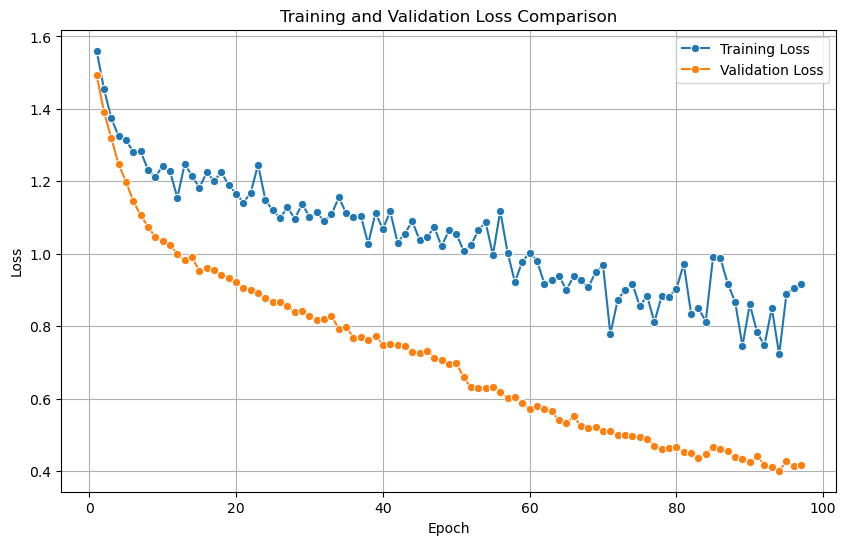

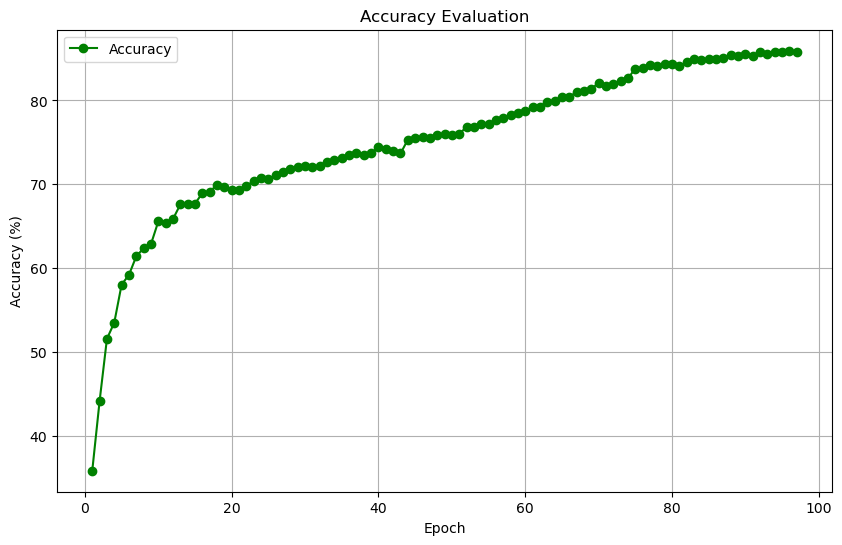

In [26]:
import torch.optim as optim

if torch.cuda.is_available():
    hardware = torch.device("cuda")
elif torch.backends.mps.is_available():
    hardware = torch.device("mps")
else:
    hardware = torch.device("cpu")
classes = 5

criterion = nn.CrossEntropyLoss()

model = LeafDiseaseClassifierMobileNetV3L(num_classes=classes).to(hardware)

model_dir = '/Users/jameskierdoliguez/Desktop/models/MobileNetV3L/MobileNetV3L_rice_leaf_disease_classificationV1.pt'
file_name = '/Users/jameskierdoliguez/Desktop/train_results/MobileNetV3L/MobileNetV3L_rice_leaf_disease_classificationV1.csv'

training_sessions = [

    {'epochs': 20, 'lr': 5e-4, 'unfreeze_layer': 0},

    {'epochs': 30, 'lr': 1e-4, 'unfreeze_layer': 1},

    {'epochs': 40, 'lr': 5e-5, 'unfreeze_layer': 2},

    {'epochs': 50, 'lr': 1e-5, 'unfreeze_layer': 3},
]

result, accuracies = incremental_training(model=model, sessions=training_sessions, criterion=criterion, train_dataloader=train_loader, validation_dataloader=validation_loader, device=hardware, model_dir=model_dir, filename=file_name)

plot_training_result(*result)
plot_accuracy(*result)

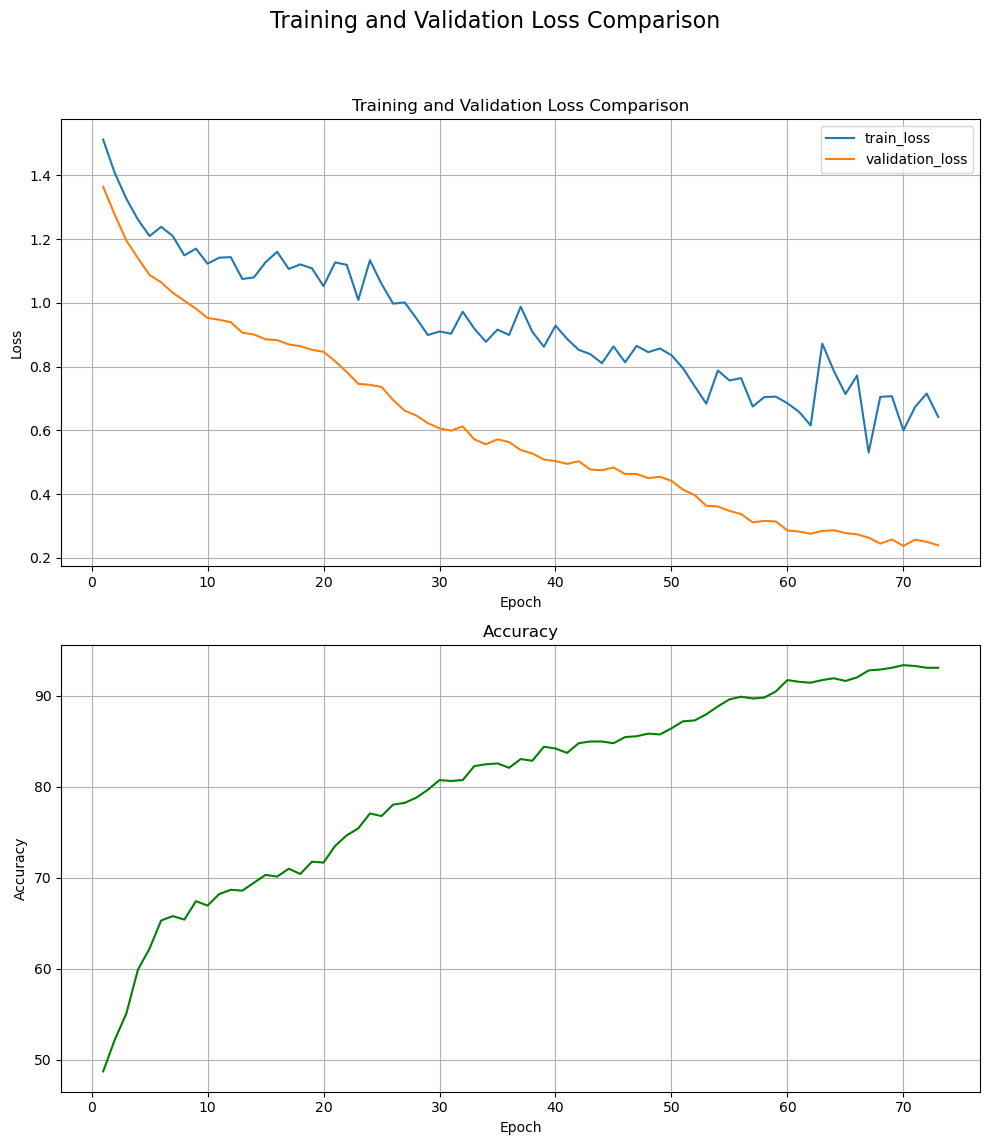

In [17]:

plot_historical_results('/Users/jameskierdoliguez/Desktop/train_results/ShuffleNetV2/ShuffleNetV2_rice_leaf_disease_classificationV1.csv')



In [19]:
from PIL import Image
import numpy as np
import torch.nn.functional as F

def predict_single_image(model, image_path, classes, transform, device):

    model.to(device)

    model.eval()

    image = Image.open(image_path).convert('RGB')

    image_np = np.array(image)

    augmented = transform(image=image_np)

    image_tensor = augmented['image'].unsqueeze(0).to(device)

    with torch.no_grad():
        result = model(image_tensor)

        probabilities = F.softmax(result, dim=1)

        confidence, predicted_index = torch.max(probabilities, 1)
        predicted_class = classes[predicted_index.item()]
        confidence_score = confidence.item()

    return predicted_class, confidence_score, probabilities.squeeze().cpu().numpy()


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

def eval_metrics(model, testLoader, classes_names, device):

    model.to(device)
    model.eval()

    total_predictions = []
    true_labels = []

    with torch.no_grad():

        for input, labels in tqdm(testLoader):
            input, labels = input.to(device), labels.to(device)

            output = model(input)
            _, predicted = torch.max(output, 1)

            total_predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())


    y_true = np.array(true_labels)
    y_pred = np.array(total_predictions)

    print('Classification Report')
    report = classification_report(y_true, y_pred, target_names=classes_names)

    print(report)

    print(f"Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%\n")

    print('Confusion Matrix')

    matrix = confusion_matrix(y_true, y_pred)

    cm_df = pd.DataFrame(matrix, index=classes_names, columns=classes_names)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix (standard)')
    plt.ylabel('Actual leaf diseases')
    plt.xlabel('Predicted leaf diseases')
    plt.show()

    return y_true, y_pred

def save_evalution_result(total_predictions, true_labels):

    data = pd.DataFrame({
        'True Labels': true_labels,
        'Predicted Labels': total_predictions
    })

    data.to_csv('evalution_result.csv', index=False)


The predicted leaf disease is: Brown Spot
Confidence: 56.42%
Overall score: [0.02641378 0.5642498  0.06463644 0.28584364 0.05885638]


100%|███████████████████████████████████████████| 17/17 [00:04<00:00,  3.69it/s]


Classification Report
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.88      0.82      0.85        88
           Brown Spot       0.89      0.83      0.86       110
           Leaf Blast       0.72      0.85      0.78       125
           Leaf scald       0.80      0.75      0.77        93
        Sheath Blight       0.94      0.91      0.92       101

             accuracy                           0.83       517
            macro avg       0.85      0.83      0.84       517
         weighted avg       0.84      0.83      0.84       517

Accuracy: 83.37%

Confusion Matrix


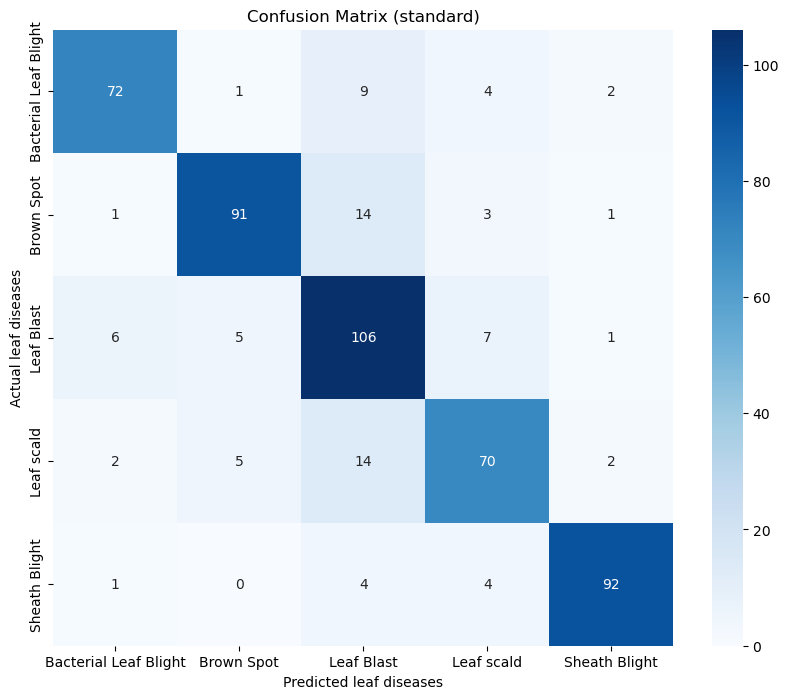

In [21]:
import torchvision.models as models

classes_names = train_set.classes
if torch.cuda.is_available():
    hardware = torch.device("cuda")
elif torch.backends.mps.is_available():
    hardware = torch.device("mps")
else:
    hardware = torch.device("cpu")
model_inference = LeafDiseaseClassifierMobileNetV2(num_classes=len(classes_names))
model_inference.load_state_dict(torch.load(
    '/Users/jameskierdoliguez/Desktop/models/MobileNetV2/MobileNetV2_rice_leaf_disease_classificationV4.pt', map_location=hardware))

image_path = '/Users/jameskierdoliguez/Desktop/rice_leaf/Bad daatset/aug_dataset/train/Bacterialblight/BACTERAILBLIGHT3_015.jpg'
unrelated = '/Users/jameskierdoliguez/Downloads/FELV-cat.jpg'

leaf_disease, confidence_score, over_all_scores = predict_single_image(model=model_inference, image_path=image_path, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted leaf disease is: {leaf_disease}")
print(f"Confidence: {confidence_score * 100:.2f}%")
print(f"Overall score: {over_all_scores}")
#
true, pred = eval_metrics(model_inference, test_loader, classes_names, hardware)

The predicted leaf disease is: Leaf scald
Confidence: 89.89%
Overall score: [0.02912802 0.04140368 0.01676862 0.8988594  0.0138403 ]


100%|███████████████████████████████████████████| 17/17 [00:05<00:00,  2.87it/s]

Classification Report
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.96      0.93      0.95        88
           Brown Spot       1.00      0.97      0.99       110
           Leaf Blast       0.93      0.97      0.95       125
           Leaf scald       0.98      1.00      0.99        93
        Sheath Blight       1.00      0.99      1.00       101

             accuracy                           0.97       517
            macro avg       0.97      0.97      0.97       517
         weighted avg       0.97      0.97      0.97       517

Accuracy: 97.29%

Confusion Matrix


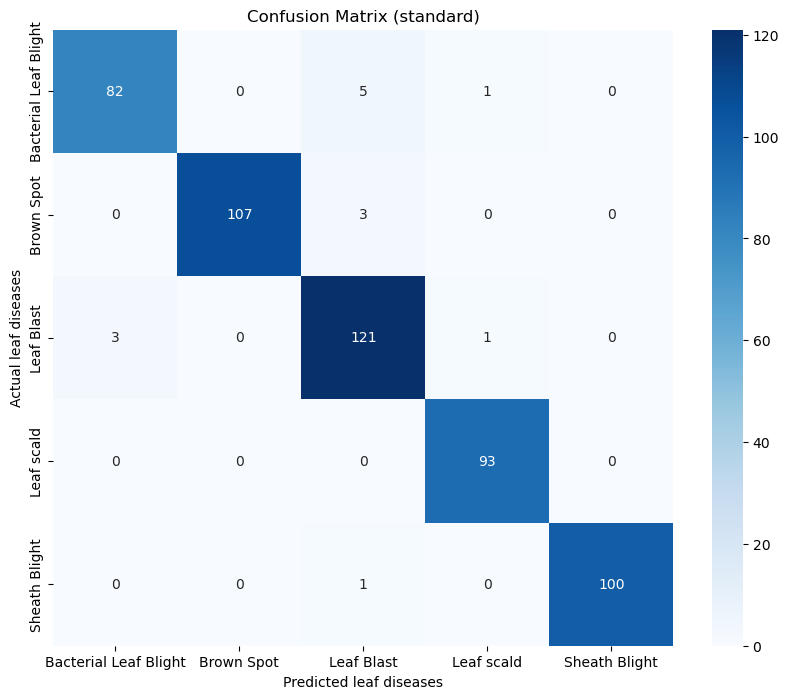

In [26]:
import torchvision.models as models

classes_names = train_set.classes
if torch.cuda.is_available():
    hardware = torch.device("cuda")
elif torch.backends.mps.is_available():
    hardware = torch.device("mps")
else:
    hardware = torch.device("cpu")
model_inference = LeafDiseaseClassifierEfficientNetV2S(num_classes=len(classes_names))
model_inference.load_state_dict(torch.load(
    '/Users/jameskierdoliguez/Desktop/models/EfficientNetV2S/EfficientNetV2S_rice_leaf_disease_classificationV2.pt', map_location=hardware))
image_path = '/Users/jameskierdoliguez/Documents/Rice_Leaf_Diease/train/bacterial_leaf_blight/bacterial_leaf_blight680.jpg'
unrelated = '/Users/jameskierdoliguez/Downloads/FELV-cat.jpg'

leaf_disease, confidence_score, over_all_scores = predict_single_image(model=model_inference, image_path=image_path, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted leaf disease is: {leaf_disease}")
print(f"Confidence: {confidence_score * 100:.2f}%")
print(f"Overall score: {over_all_scores}")

true, pred = eval_metrics(model_inference, test_loader, classes_names, hardware)

The predicted leaf disease is: Bacterial Leaf Blight
Confidence: 36.66%
Overall score: [0.36662865 0.22544892 0.030272   0.213752   0.16389844]


100%|███████████████████████████████████████████| 17/17 [00:04<00:00,  3.94it/s]

Classification Report
                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.91      0.92      0.92        88
           Brown Spot       0.92      0.94      0.93       110
           Leaf Blast       0.91      0.88      0.89       125
           Leaf scald       0.94      0.94      0.94        93
        Sheath Blight       0.97      0.98      0.98       101

             accuracy                           0.93       517
            macro avg       0.93      0.93      0.93       517
         weighted avg       0.93      0.93      0.93       517

Accuracy: 92.84%

Confusion Matrix


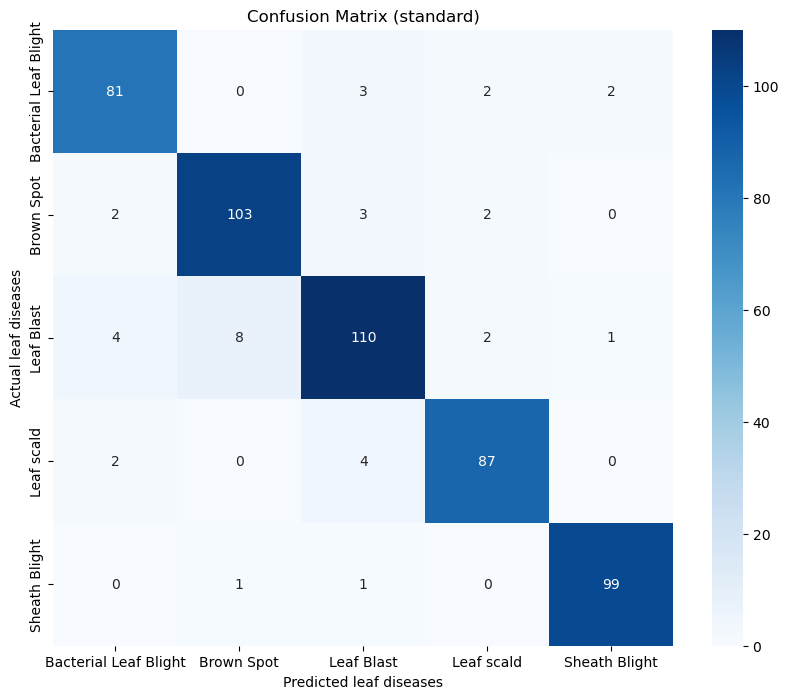

In [22]:
import torchvision.models as models

classes_names = train_set.classes
if torch.cuda.is_available():
    hardware = torch.device("cuda")
elif torch.backends.mps.is_available():
    hardware = torch.device("mps")
else:
    hardware = torch.device("cpu")
model_inference = LeafDiseaseClassifierShuffleNetV2(num_classes=len(classes_names))
model_inference.load_state_dict(torch.load(
    '/Users/jameskierdoliguez/Desktop/models/ShuffleNetV2/ShuffleNetV2_rice_leaf_disease_classificationV1.pt', map_location=hardware))
image_path = '/Users/jameskierdoliguez/Documents/Rice_Leaf_Diease/train/bacterial_leaf_blight/bacterial_leaf_blight680.jpg'
unrelated = '/Users/jameskierdoliguez/Downloads/FELV-cat.jpg'

leaf_disease, confidence_score, over_all_scores = predict_single_image(model=model_inference, image_path=image_path, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted leaf disease is: {leaf_disease}")
print(f"Confidence: {confidence_score * 100:.2f}%")
print(f"Overall score: {over_all_scores}")

true, pred = eval_metrics(model_inference, test_loader, classes_names, hardware)